In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

%matplotlib inline

Autoenkoder predstavlja neuronsku mrezu koja vrsi nelinaerno smanjivanje dimenzionalnosti podataka.

Sastoji se iz dva dela:
- Enkodera
- Dekodera

**Enkoder** predstavlja deo mreze koji ulaz dimenzije $A$ preslikava u vektor dimenzije $B$, pri cemu vazi da je $A > B$, odnosno
vrsi se smanjivanje dimenzionalnosti. Vektor dimezije $B$ nazivamo vektorom latentnog prostora dimenzije $B$.

**Dekoder** dimenziju $B$ preslikava u dimenziju $A$, odnosno vrsi rekonstrukciju ulaza od vektora iz latentnog prostora.

Obucavanje autoenkodera se vrsi kao obucavanje standardne neuronske mreze u klasifikacionim i regresionim problemima.

<img src='autoencoder.png'>

In [12]:
# Ucitavamo MNIST podatke (labele nam nisu potrebne za autoenkoder).
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
print('image_size: {}'.format(image_size))

image_size: 28


In [13]:
# Dodajemo dodatnu dimenziju u sliku koja predstavlja jedan kanal.
x_train = np.reshape(x_train, (-1, image_size, image_size, 1))
x_test = np.reshape(x_test, (-1, image_size, image_size, 1))
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train.shape: {}'.format(x_train.shape))

x_train.shape: (60000, 28, 28, 1)


Generisemo sum iz raspodele $N(0.5, 0.5)$ koji dodajemo na slike.

In [ ]:
# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# Odsecamo vrednosti koje su ispale iz opsega [0, 1].
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

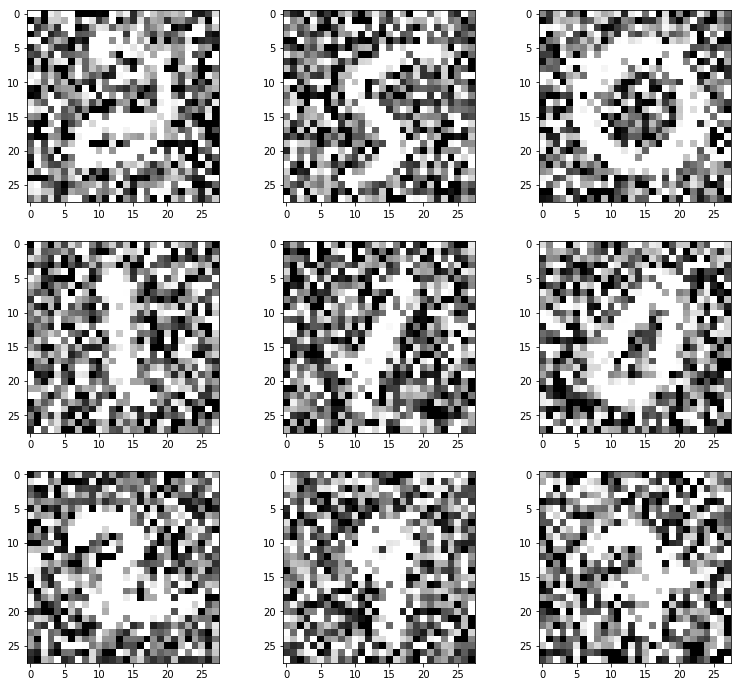

In [15]:
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(13, 12)
i = 0
ix = np.random.randint(low=0, high=x_train_noisy.shape[0], size=(nrows*ncols))

# Uzimamo (nrows*ncols) nasumicnih slika
chosen_imgs = x_train_noisy[ix]

for row in ax:
    for col in row:
        # Radimo reshape (image_size, image_size, 1) u (image_size, image_size) jer matplotlib to zahteva zbog crtanja.
        img = chosen_imgs[i].reshape(image_size, image_size)
        col.imshow(img, cmap='gray')
        i += 1

Definisemo parametre mreze.

Ulaz u mrezu je tensor oblika $(28, 28, 1)$ gde je $28 \times 28$ dimezija slike, a $1$ oznacava da postoji 1 kanal jer su slike crno bele.

Slike dimenzija $28 \times 28$ cemo preslikavati u vektor dimenzije 16 (`latent_dim=16`).

In [ ]:
# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16

# Broj filtera u konvolutivnim slojevima.
layer_filters = [32, 64]

### Enkoder
Preslikava (28, 28, 1) u vektor dimenzije 16.

In [17]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Izvlacimo shape za tensor (slicno kao shape za numpy n-dimenzioni niz).
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


### Dekoder.
Dekoder preslikava vektor dimenzije 16 u dimenziju (28, 28, 1).

In [18]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# layer_filters[::-1] -> obrcemo filtere (produzena python sintaksa, -1 oznacava korak)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0         
Total para

Koristimo konstruisane modele da napravimo autoenkoder.

In [19]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


Vrsimo obucavanje autoenkodera. Primetimo da se autoenkoder obucava na instancama na kojima je dodat sum,
a kao ciljna promenljiva se postavljaju instance na kojima ne postoji sum.

In [20]:
# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 10s 162us/step - loss: 0.0643 - val_loss: 0.0356
Epoch 2/30
60000/60000 [==============================] - 9s 151us/step - loss: 0.0268 - val_loss: 0.0222
Epoch 3/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0211 - val_loss: 0.0197
Epoch 4/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0193 - val_loss: 0.0185
Epoch 5/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0183 - val_loss: 0.0178
Epoch 6/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0176 - val_loss: 0.0175
Epoch 7/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0172 - val_loss: 0.0171
Epoch 8/30
60000/60000 [==============================] - 9s 149us/step - loss: 0.0168 - val_loss: 0.0169
Epoch 9/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0165 - val_loss: 0.

In [21]:
! nvidia-smi

Tue May 14 14:59:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    66W / 149W |    450MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols

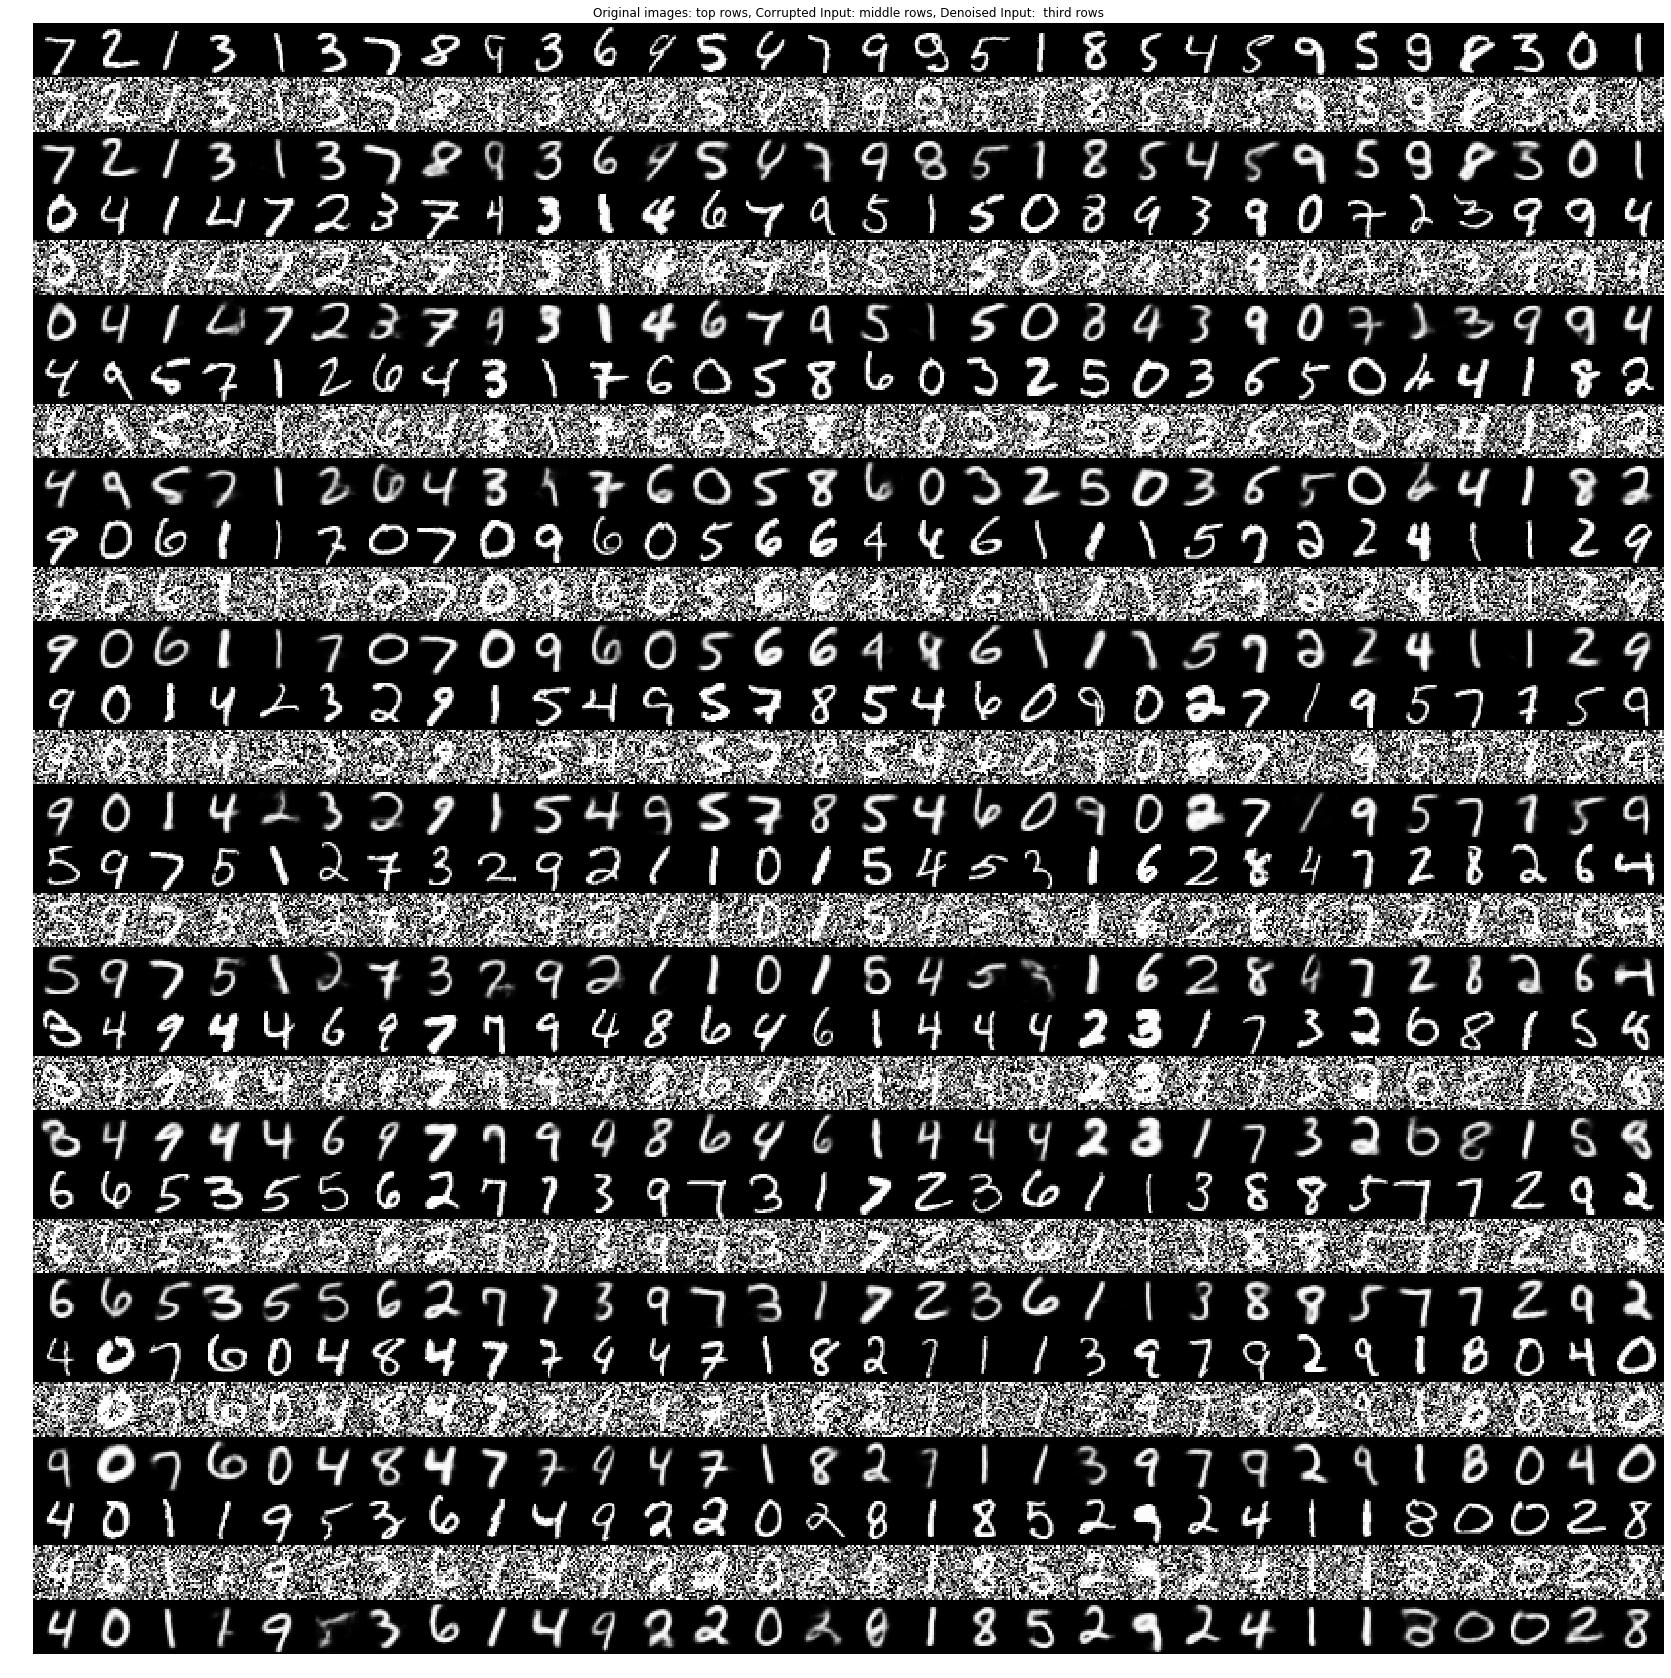

In [24]:
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()